# Conv4 3D Residual v2

### Here we visualize performance of the network on validation set for different signal classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from cnn_utils import *

Using TensorFlow backend.


In [2]:
from keras.models import  load_model
import tensorflow as tf
import keras.backend as K

# TensorFlow wizardry
#config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)

tf.logging.set_verbosity(tf.logging.ERROR)
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices() if "GPU" in d.name]

['XLA_GPU 16384 Mb', 'GPU 2391 Mb']

In [3]:
N_ep = 10; batch = 100; i=0; n_fold = 4
class_names = ['C30keV','C60keV','C100keV']
load_s = []
for n in class_names:
    load_s += [(n+str(i)) for i in range(1,n_fold+1)]
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_clean.h5'

In [4]:
conv_model, preds, X, y, shuffs = {},{},{},{},{}
for s in load_s:
    conv_model[s] = load_model('networks/res_v2/e'+str(N_ep)+'/conv4_3d_res_'+s[:-1]+'_'+s[-1]+'.h5', custom_objects={'swish':swish})
for n in class_names:
    print('\t'+n+' vs gamma')
    X[n], y[n], shuffs[n] = load_data_v2(classes={'s_'+n:'full','b_gamma':'full'}, tr_val_test=[False,True,False],
                                         im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1)
    for s in load_s:
        preds[n+'_'+s] = conv_model[s].predict(X[n]['/images/val'], batch_size=batch, verbose=0)
        np.savetxt('outputs/conv4_3d_res/v2/preds/'+'e'+str(N_ep)+'_'+n+'_'+s+'.txt',preds[n+'_'+s])
    print('')
'saving predictions for validation sets'

	C30keV vs gamma
Number of C30keV samples: 	 13041
Number of gamma samples: 	 8843

	C60keV vs gamma
Number of C60keV samples: 	 12695
Number of gamma samples: 	 8843

	C100keV vs gamma
Number of C100keV samples: 	 12982
Number of gamma samples: 	 8843



'saving predictions for validation sets'

Model trained on C30keV vs gamma



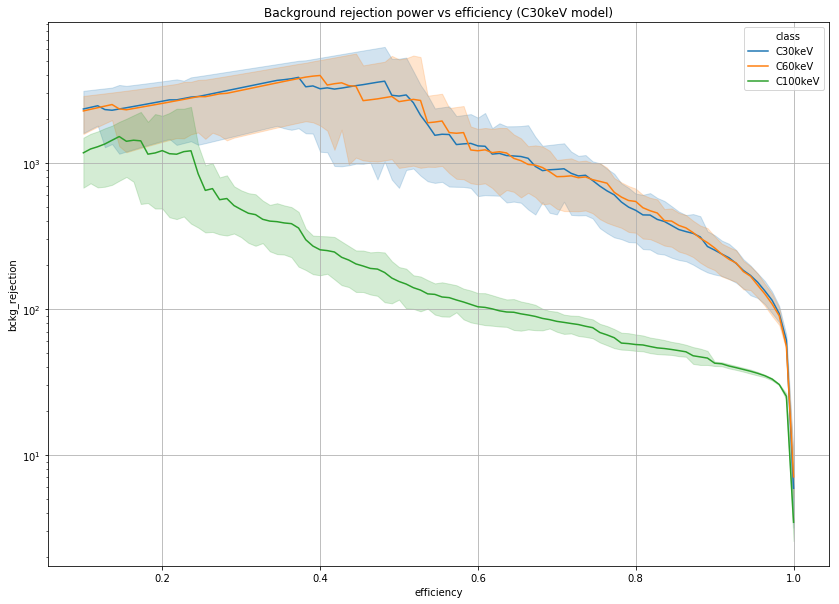




If we call inverse_threshold = 1/(1-threshold) to explore the region of probability threshold close to 1




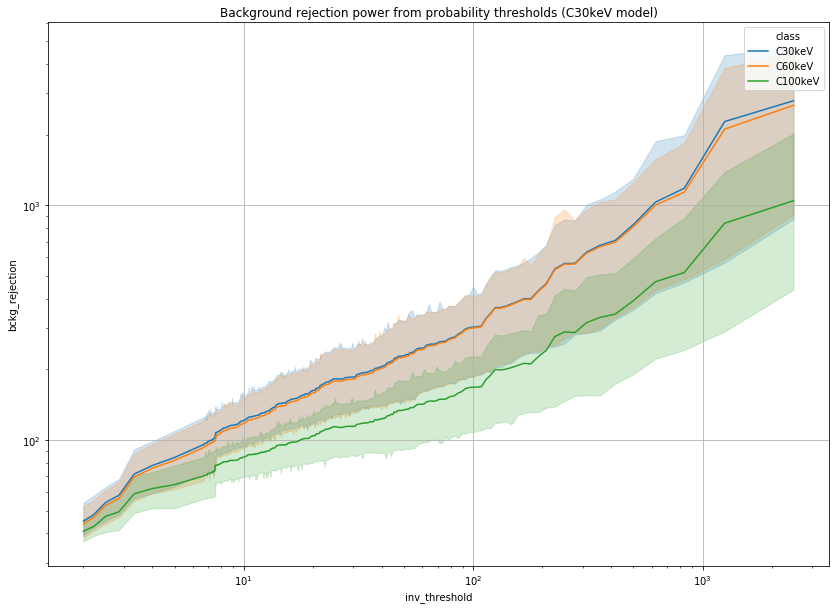

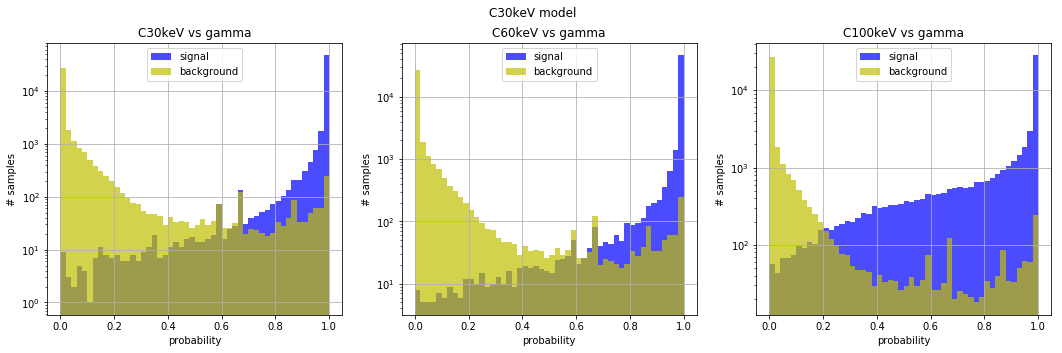




Model trained on C60keV vs gamma



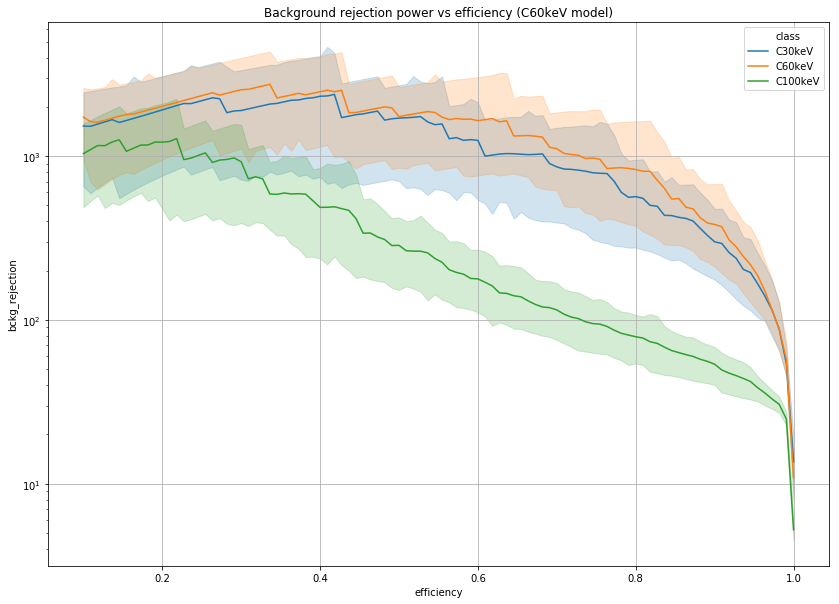




If we call inverse_threshold = 1/(1-threshold) to explore the region of probability threshold close to 1




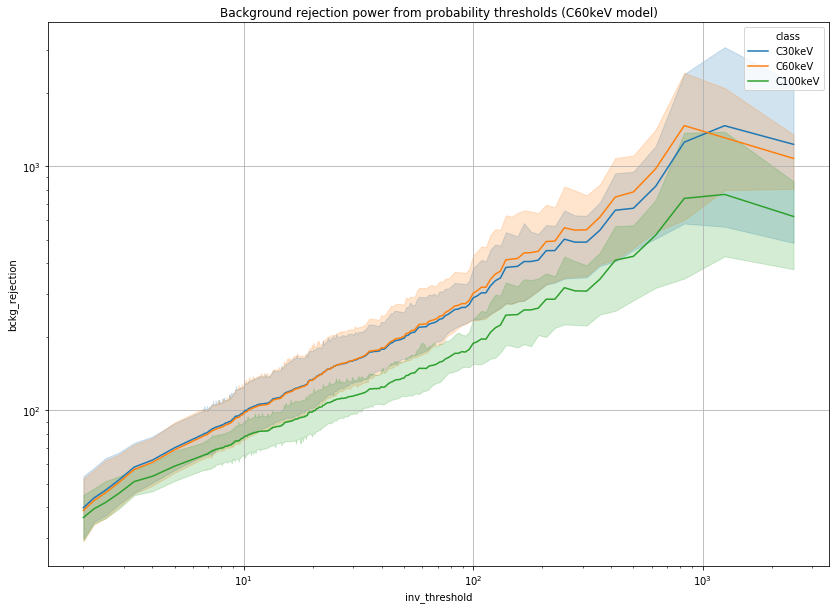

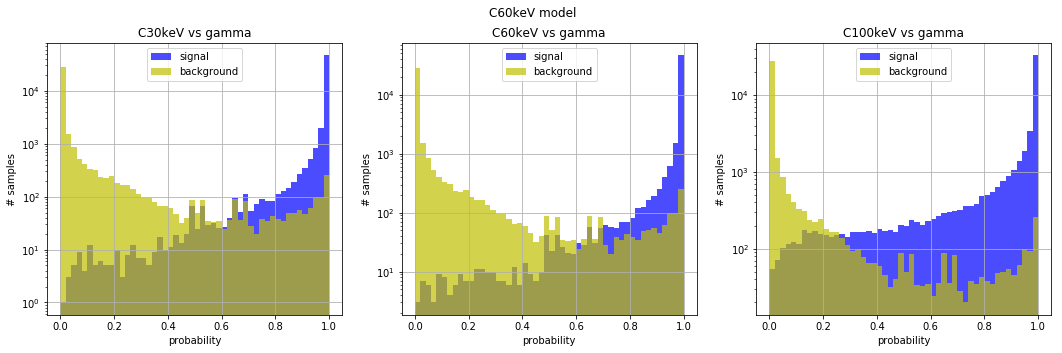




Model trained on C100keV vs gamma



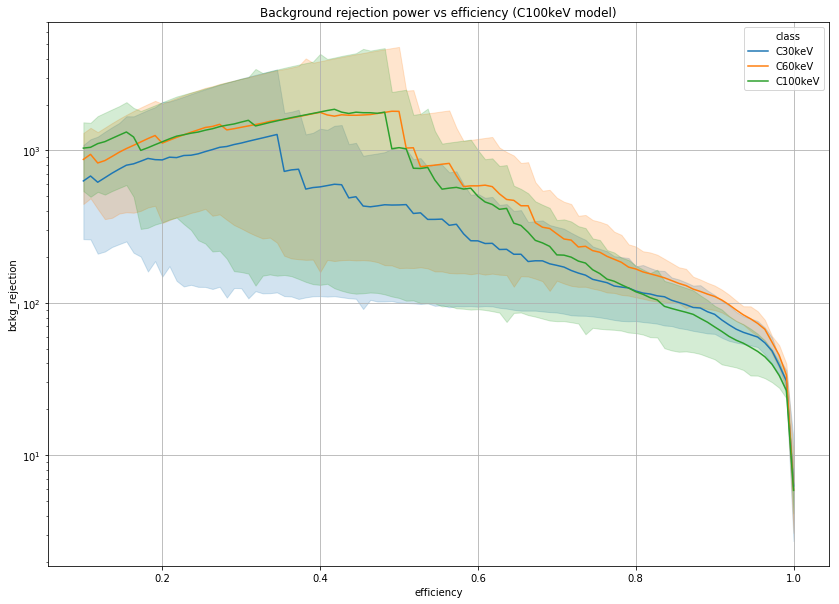




If we call inverse_threshold = 1/(1-threshold) to explore the region of probability threshold close to 1




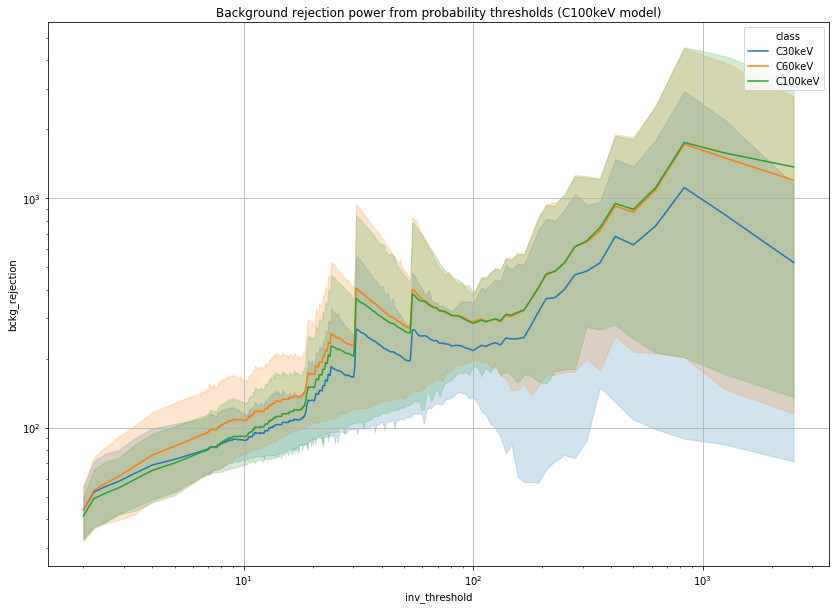

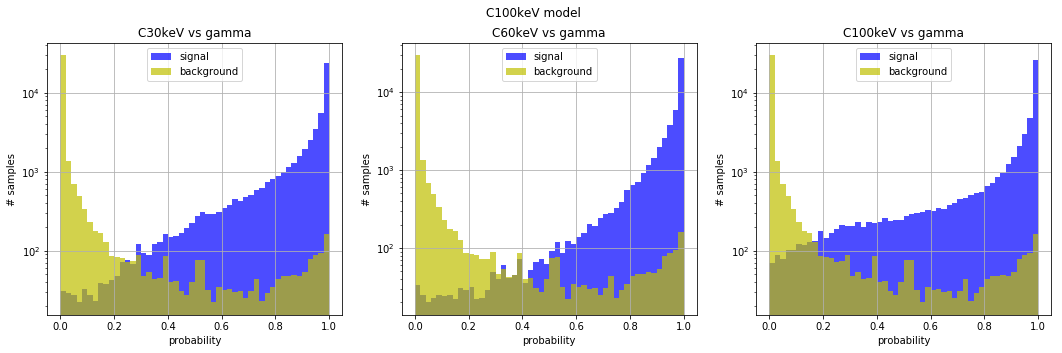

In [12]:
# cross-class model behavior
pr_curves, min_eff, interp = {},{},{}
thr_curves, min_thr, inter_thr = {},{},{}
for n in class_names:
    min_eff[n] = 0.1
    min_thr[n] = 0.1
    for s in load_s:
        prec, rec, thresh = precision_recall_curve(y[n]['/images/val'], preds[n+'_'+s])
        if rec[-2]>min_eff[n]: min_eff[n] = rec[-2] # avoiding extrapolation
        if thresh[0]>min_thr[n]: min_thr[n] = thresh[0] # avoiding extrapolation
        mask = np.ones(len(rec),dtype=bool); mask[-1]=False
        for i,pr in enumerate(prec[:-1]):
            if not pr or abs(1-pr)<1e-6 or abs(1-thresh[i])<1e-6: mask[i] = False
        rec = rec[mask]; prec = prec[mask]; thresh = thresh[mask[:-1]]
        interp[n+'_'+s] = sp.interpolate.interp1d(rec, prec, fill_value='extrapolate')
        inter_thr[n+'_'+s] = sp.interpolate.interp1d(thresh, prec, fill_value='extrapolate')
        _ = gc.collect()

pr_curves['class'], pr_curves['bckg_rejection'], pr_curves['efficiency'], pr_curves['model'] = [],[],[],[]
thr_curves['class'], thr_curves['bckg_rejection'], thr_curves['inv_threshold'], thr_curves['model'] = [],[],[],[]
thr = np.append(np.arange(0.5,0.85,5e-2),np.arange(0.85,1-1e-5,4e-4))
for n in class_names:
    eff = list(np.linspace(min_eff[n],1.0, num=100))
    for s in load_s:
        pr_curves['class'] += [n]*len(eff)
        pr_curves['efficiency'] += eff
        pr_curves['bckg_rejection'] += list((1-interp[n+'_'+s](eff)+1e-6)**-1)
        pr_curves['model'] += [s[:-1]]*len(eff)
        thr_curves['class'] += [n]*len(thr)
        thr_curves['inv_threshold'] += list((1-np.array(thr)+1e-6)**-1)
        thr_curves['bckg_rejection'] += list((1-inter_thr[n+'_'+s](thr)+1e-6)**-1)
        thr_curves['model'] += [s[:-1]]*len(thr)
pr_curves = pd.DataFrame(data=pr_curves)
thr_curves = pd.DataFrame(data=thr_curves)

for n in class_names:
    # n is a MODEL trained on corresponding data
    print('Model trained on '+n+' vs gamma\n')    
    if not any([n in s for s in load_s]): continue
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='efficiency',y='bckg_rejection',hue='class', data=pr_curves[pr_curves['model']==n])
    plt.grid()
    plt.yscale('log')
    plt.title('Background rejection power vs efficiency ('+n+' model)')
    plt.show()   

    print('\n\n\nIf we call inverse_threshold = 1/(1-threshold) to explore the region of probability threshold close to 1\n\n')

    plt.figure(figsize=(14,10))
    sns.lineplot(x='inv_threshold',y='bckg_rejection',hue='class', data=thr_curves[thr_curves['model']==n])
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Background rejection power from probability thresholds ('+n+' model)')
    plt.show()

    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, k in enumerate(class_names):
        #if k!='C100keV': continue
        pos[k+'_'+n], neg[k+'_'+n] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s], neg[k+'_'+s] = pos_neg(y[k]['/images/val'], preds[k+'_'+s])
            pos[k+'_'+n] = np.vstack((pos[k+'_'+n],pos[k+'_'+s]))
            neg[k+'_'+n] = np.vstack((neg[k+'_'+n],neg[k+'_'+s]))
        axes[i].hist(pos[k+'_'+n][:,0], bins=50, alpha=0.7, label='signal', range=(0,1), color='b')
        axes[i].hist(neg[k+'_'+n][:,0], bins=50, alpha=0.7, label='background', range=(0,1), color='y')
        axes[i].grid()
        axes[i].set_title(k+' vs gamma')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend()
    plt.suptitle(n+' model')
    plt.show()

    print('\n\n')

In [8]:
conv_model['C100keV1'].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 8, 1)  0                                            
____________________________________________________________________________________________________
conv1_1 (Conv3D)                 (None, 32, 32, 8, 64) 1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv3D)                 (None, 32, 32, 8, 64) 110656      conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling3D)             (None, 16, 16, 4, 64) 0           conv1_2[0][0]                    
___________________________________________________________________________________________